In [1]:
import time
import datetime
import numpy as np
import scipy as sp
import pandas as pd

from itertools import product
from nltk.corpus import stopwords
from scipy.sparse import hstack

from sklearn import decomposition, metrics
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, roc_curve, mean_squared_error, make_scorer
from sklearn.pipeline import FeatureUnion
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction import text

from utility.processing import processer
from utility.utility import *

from imblearn.combine import *
from imblearn.over_sampling import *
from imblearn.under_sampling import * 
from imblearn.pipeline import Pipeline

%matplotlib inline

# LSA

## 데이터 로드

In [2]:
train = pd.read_csv('./data/preprocessed_train.csv')
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)
y = train.median_relevance.values

In [3]:
train, dev, y, y_dev = train_test_split(train, y, stratify=y, test_size=0.1)

In [4]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

dev_query = list(dev.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
dev_title = list(dev.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

## 모델링

### TF-IDF

In [5]:
# min_df=3 : 빈도수가 3번 이하인 단어 무시  
# max_features=None : 단어 빈도수의 맥시멈 설정 x
# strip_accents='unicode' : 모든 특수문자와 pattern을 정재할수 없으므로 unicode사용       
# analyzer='word' : corpus가 문장 list로 이루어져있어 단어단위로 분석  
# token_pattern=r'\w{1,}' : analyzer == 'word'일 때 token_pattern을 기반으로 단어 인식   
# ngram_range=(1, 3) : word window의 범위 1~3, 약 90% 쿼리가 word size 3이하로 이루어짐  
# use_idf=True : idf사용   
# smooth_idf=True : 분모가 0이 되는것을 방지  
# sublinear_tf=True : 단어 스무딩, replace 1 + log(tf).   
# stop_words : 불용어 제거  
stop_words = text.ENGLISH_STOP_WORDS.union(['http','www','img','border','color','style','padding','table','font', '',\
                                            'thi','inch','ha','width','height','0','1','2','3','4','5','6','7','8','9'])
stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))

tfv = text.TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}', \
                           ngram_range=(1, 3), use_idf=True, smooth_idf=True, sublinear_tf=True, \
                           stop_words=stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_dev = hstack([tfv.transform(dev_query), tfv.transform(dev_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

In [6]:
# 단어별 가중치 확인
# idf_dict = dict(zip(tfv.get_feature_names(), tfv.idf_))

### cos, jaccard similarlity

In [7]:
# query, title 유사도 계산(cos, jaccard)
sim = similarlity_stack()
X_sim_train = sim.fit_transform(X_train, y)
X_sim_dev = sim.transform(X_dev)
X_sim_test = sim.transform(X_test)

In [8]:
for i in range(1, 5):
    sims = X_sim_train.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ratings 1 
cos_sim mean : 0.134786	 jaccard_sim mean: 0.089424

ratings 2 
cos_sim mean : 0.226628	 jaccard_sim mean: 0.156125

ratings 3 
cos_sim mean : 0.281881	 jaccard_sim mean: 0.194499

ratings 4 
cos_sim mean : 0.358388	 jaccard_sim mean: 0.251528



#### LogisticRegression

In [11]:
lr = LogisticRegression(max_iter=500)

X_train_sim = hstack([X_train, X_sim_train])
X_dev_sim = hstack([X_dev, X_sim_dev])

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr without sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

kappa_scores = cross_val_score(lr, X_train_sim, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("lr with sim kappa score 평균 : %0.2f, 편차 : %0.2f" % (np.mean(kappa_scores), np.std(kappa_scores)))

lr without sim kappa score 평균 : 0.50, 편차 : 0.02
lr with sim kappa score 평균 : 0.57, 편차 : 0.03


### LSA

In [12]:
# TruncatedSVD
# 261개의 쿼리이므로 n_components = 250로 모델링 시작
svd = TruncatedSVD(n_components = 250)
X_svd_train = svd.fit_transform(X_train)
X_svd_dev = svd.transform(X_dev)
X_svd_test = svd.transform(X_test)

In [13]:
# LSA 이후의 유사도 계산
# TF-IDF로 구한 유사도 보다 높은값이지만 증가비율은 비슷함
tfidf_hat = np.dot(X_svd_train, svd.components_)
cos_sims = []
jaccard_sims = []
half = 10316
for row in tfidf_hat:
    front = row[:half]
    end = row[half:]
    cos_sims.append(metric.cos_sim(front, end))
    jaccard_sims.append(metric.jaccard_sim(front, end))
    
simsim = sparse.csr_matrix(np.matrix([x for x in zip(cos_sims, jaccard_sims)]))

for i in range(1, 5):
    sims = simsim.toarray()[np.where(y == i)].sum(axis=0)/len(np.where(y == i)[0])
    print("ratings %d \ncos_sim mean : %f\t jaccard_sim mean: %f\n" % (i, sims[0], sims[1]))

ValueError: shapes (10316,) and (10272,) not aligned: 10316 (dim 0) != 10272 (dim 0)

In [ ]:
# Truncated SVD와 유사도 hstack
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_stacked_dev = hstack([X_svd_dev, X_sim_dev])
X_stacked_test = hstack([X_svd_test, X_sim_test])

In [ ]:
# StandardScaler
# with_mean=False 행렬이 희소하고 [0,1]이므로 mean shift사용 X
scl = StandardScaler(with_mean=False)
X_scaled_train = scl.fit_transform(X_stacked_train)
X_scaled_dev = scl.transform(X_stacked_dev)
X_scaled_test = scl.transform(X_stacked_test)

### classification(LogisticRegression)

In [ ]:
lr = LogisticRegression(max_iter=500)

cv = StratifiedKFold(n_splits=5, shuffle=True)
kappa_scores = cross_val_score(lr, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("kappa score 평균 : %0.2d, 편차 : %0.2d" % (np.mean(kappa_scores), np.std(kappa_scores)))

### classification(SVM)

In [ ]:
# C=100(패널티) 문서당 유사도가 크기때문에(쿼리의 중복) 100으로 잡고 시작
svm = SVC(C = 100, gamma='auto', probability=True)

kappa_scores = cross_val_score(svm, X_scaled_train, y, \
                               scoring=make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), cv=cv)
print("kappa score 평균 : %0.2d, 편차 : %0.2d" % (np.mean(kappa_scores), np.std(kappa_scores)))

## 모델링 결과 해석

In [ ]:
svm_result = svm.fit(X_scaled_train, y)
svm_pred_dev = svm_result.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y, svm_pred_train), \
                                      metric.quadratic_weighted_kappa(y_dev, svm_pred_dev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y, svm_pred_train)**0.5, \
                                     mean_squared_error(y_dev, svm_pred_dev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svm_pred_dev!=y_dev)[0])), \
      metrics.confusion_matrix(y_dev, svm_pred_dev))

print('\nclassification_report :\n', classification_report(y_dev, svm_pred_dev))

plot_multiclass_roc_prc(svm, X_scaled_dev, y_dev)

## 개선된 모델

kappa
train : 0.966579	dev : 0.615538
rmse
train : 0.288649	dev : 0.857459

confusion_matrix : 1016개중 379개를 틀림
 [[ 47  20   3   7]
 [ 20  55  36  37]
 [  6  24  62  82]
 [  6  42  96 473]]

classification_report :
               precision    recall  f1-score   support

           1       0.59      0.61      0.60        77
           2       0.39      0.37      0.38       148
           3       0.31      0.36      0.33       174
           4       0.79      0.77      0.78       617

    accuracy                           0.63      1016
   macro avg       0.52      0.53      0.52      1016
weighted avg       0.64      0.63      0.63      1016



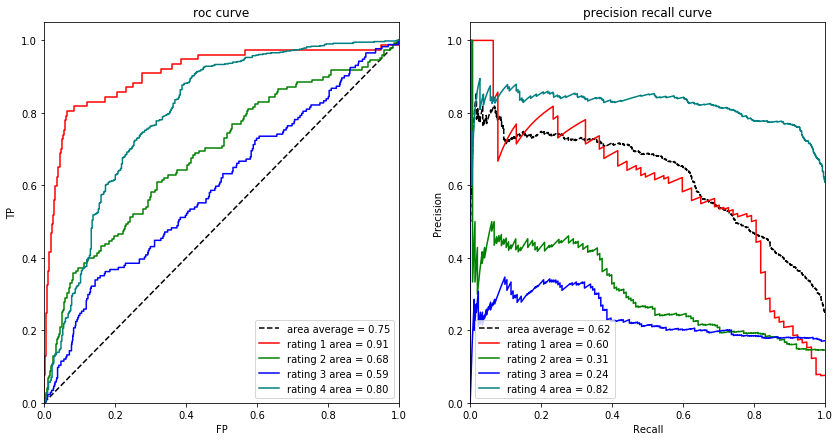

In [28]:
smt = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X_samp, y_samp = smt.fit_sample(X_scaled_train, y)

svm = SVC(C=100, gamma='auto', class_weight='balanced'  probability=True)
svmresult = svm.fit(X_samp, y_samp)

svmpredtrain = svmresult.predict(X_samp)
svmpreddev = svmresult.predict(X_scaled_dev)

print("kappa\ntrain : %f\tdev : %f"% (metric.quadratic_weighted_kappa(y_samp, svmpredtrain), \
                                      metric.quadratic_weighted_kappa(y_dev, svmpreddev)))

print("rmse\ntrain : %f\tdev : %f"% (mean_squared_error(y_samp, svmpredtrain)**0.5, \
                                     mean_squared_error(y_dev, svmpreddev)**0.5))

print('\nconfusion_matrix : %d개중 %d개를 틀림\n'%(len(y_dev), len(np.where(svmpreddev!=y_dev)[0])), \
      metrics.confusion_matrix(y_dev, svmpreddev))
print('\nclassification_report :\n', classification_report(y_dev, svmpreddev))

plot_multiclass_roc_prc(svmresult, X_scaled_dev, y_dev)

#### GridSearchCV(SVM)

In [2]:
# df_train = pd.read_csv('./data/preprocessed_train.csv')
# Y = df_train['median_relevance']
# test = pd.read_csv('./data/preprocessed_test.csv')
# idx = test.id.values.astype(int)

# # n_components, C, gamma
# parmas = [[230], [1000], ['auto']]
# parmas = list(product(*parmas))

# # results = gridsearchcv(df_train, Y, parmas)

### 최종 모델

In [ ]:
train = pd.read_csv('./data/preprocessed_train.csv')
y = train['median_relevance']
test = pd.read_csv('./data/preprocessed_test.csv')
idx = test.id.values.astype(int)

In [ ]:
param_grid = {'n_components' : 230,\
              'C' : 100,\
              'gamma' : 'auto'}

In [ ]:
train_query = list(train.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
train_title = list(train.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

test_query = list(test.apply(lambda x:'%s' % x['query_preprocessed'], axis=1))
test_title = list(test.apply(lambda x:'%s' % x['product_title_preprocessed'], axis=1))

stop_words = text.ENGLISH_STOP_WORDS.union(['http','www','img','border','color','style','padding','table',\
                                            'font', '', 'thi','inch','ha','width','height',\
                                            '0','1','2','3','4','5','6','7','8','9'])

stop_words = text.ENGLISH_STOP_WORDS.union(set(stopwords.words('english')))
tfv = text.TfidfVectorizer(min_df=3,  max_features=None, strip_accents='unicode', analyzer='word',\
                           token_pattern=r'\w{1,}', ngram_range=(1, 3), use_idf=True, smooth_idf=True, \
                           sublinear_tf=True, stop_words = stop_words).fit(train_query + train_title)

X_train = hstack([tfv.transform(train_query), tfv.transform(train_title)])
X_test = hstack([tfv.transform(test_query), tfv.transform(test_title)])

sim = similarlity_stack()
svd = TruncatedSVD(n_components = param_grid['n_components'])
scl = StandardScaler(with_mean=False)
smote = SMOTE(sampling_strategy='auto')
svm = SVC(C=param_grid['C'], gamma=param_grid['gamma'], probability=True)

X_sim_train = sim.fit_transform(X_train, y)
X_svd_train = svd.fit_transform(X_train)
X_stacked_train = hstack([X_svd_train, X_sim_train])
X_scaled_train = scl.fit_transform(X_stacked_train)

X_sim_test = sim.transform(X_test)       
X_svd_test = svd.transform(X_test)
X_stacked_test = hstack([X_svd_test, X_sim_test])
X_scaled_test = scl.transform(X_stacked_test)

X_samp, y_samp = smote.fit_sample(X_scaled_train, y)

svm_result = svm.fit(X_samp, y_samp)
svm_pred_test = svm_result.predict(X_scaled_test)
            
# submission = pd.DataFrame({"id": idx, "prediction": svm_pred_test})
# submission.to_csv("./submission/submission.csv", index=False)
# submission.head()

In [ ]:
sim = similarlity_stack()
svd = TruncatedSVD()
scl = StandardScaler(with_mean=False)
sampling = OneSidedSelection()
svm =  SVC(gamma='auto', class_weight='balanced', probability=True)

clf = Pipeline([('FeatureUnion', FeatureUnion( [('svd', svd), ('sim', sim)] )),\
                ('scl', scl),\
                ('sampling', sampling),\
                ('svm', svm)])


svd__n_components = [230]
sampling__sampling_strategy = ['majority']
svm__C = [100]

param_grid = {'FeatureUnion__svd__n_components' : svd__n_components,\
              'sampling__sampling_strategy' : sampling__sampling_strategy,\
              'svm__C': svm__C}

scoring = {'kappa': make_scorer(metric.quadratic_weighted_kappa, greater_is_better = True), \
           'pr_auc': make_scorer(metric.pr_auc_score, greater_is_better = True, needs_proba=True, average='micro')}

import os
cv = os.cpu_count()
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scoring, \
                     refit='kappa', verbose=10, n_jobs=-1, iid=True, cv=cv)

model.fit(X_train, y)
results = pd.DataFrame(model.cv_results_)
# results.to_csv("./gridsearch/results.csv", index=False)

In [161]:
# best 점수, parameters 확인
print("Best score: %0.3f" % model.best_score_)
print("Best parameters :")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.487
Best parameters :
	FeatureUnion__svd__n_components: 300
	sampling__sampling_strategy: 'not minority'


In [ ]:
best_model = model.best_estimator_
best_model.fit(X_train, y)
dev_preds = best_model.predict(X_dev)
model_preds = best_model.predict(X_test)

In [ ]:
print(metrics.confusion_matrix(y_dev, dev_preds))
print(classification_report(y_dev, dev_preds))
plot_multiclass_roc_prc(best_model, X_dev, y_dev)

In [134]:
# # save submission
# grid_svm_sim_submission = pd.DataFrame({"id": idx, "prediction": model_preds})
# grid_svm_sim_submission.to_csv("./submission/tfidf_svm_sim_grid.csv", index=False)
# grid_svm_sim_submission.head()

,id,prediction
0,3,4
1,6,3
2,9,3
3,11,4
4,12,4
